In [1]:
import sweetviz as sv
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

c:\Users\Pc\anaconda3\envs\JBapp\Lib\site-packages\sweetviz\graph.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [ ]:
# Loading the dataset
df = pd.read_csv('da_internship_task_dataset.csv')
df = pd.DataFrame(df)

**Basic info**

In [ ]:
print(df.info(), "\n")
print(df.describe(), "\n")
print(df.isnull().sum(), "\n")  #no missing values
print(df["uuid"].nunique(), "\n")  #number of unique users
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122746 entries, 0 to 122745
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   uuid          122746 non-null  object 
 1   day_id        122746 non-null  object 
 2   license       122746 non-null  object 
 3   model         122746 non-null  object 
 4   feature       122746 non-null  object 
 5   requests_cnt  122746 non-null  float64
 6   spent_amount  122746 non-null  float64
dtypes: float64(2), object(5)
memory usage: 6.6+ MB
None 

        requests_cnt   spent_amount
count  122746.000000  122746.000000
mean       51.260742      12.227798
std       167.977380      37.588494
min         1.000000       0.270000
25%        18.000000       5.140000
50%        32.000000       8.020000
75%        54.000000      13.060000
max     12900.000000    2599.000000 

uuid            0
day_id          0
license         0
model           0
feature         0
requests_cnt    0
s

In [ ]:
#Optional, but I like to use Sweetviz reports for EDA

#sweetviz report
#report = sv.analyze(df)
#report.show_html('Sweetviz_Report_Pairwise.html')

**relationship between spent_amount and requests_cnt**

Correlation between requests_cnt and spent_amount: 0.9441770579957468


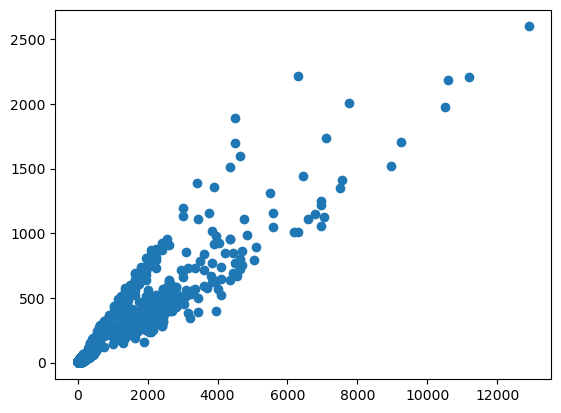

In [4]:
plt.scatter(df['requests_cnt'], df['spent_amount'])

#correlation 
correlation = np.corrcoef(df['requests_cnt'], df['spent_amount'])[0, 1]
print(f'Correlation between requests_cnt and spent_amount: {correlation}')

**user-based spent_amount and requests_cnt analysis**

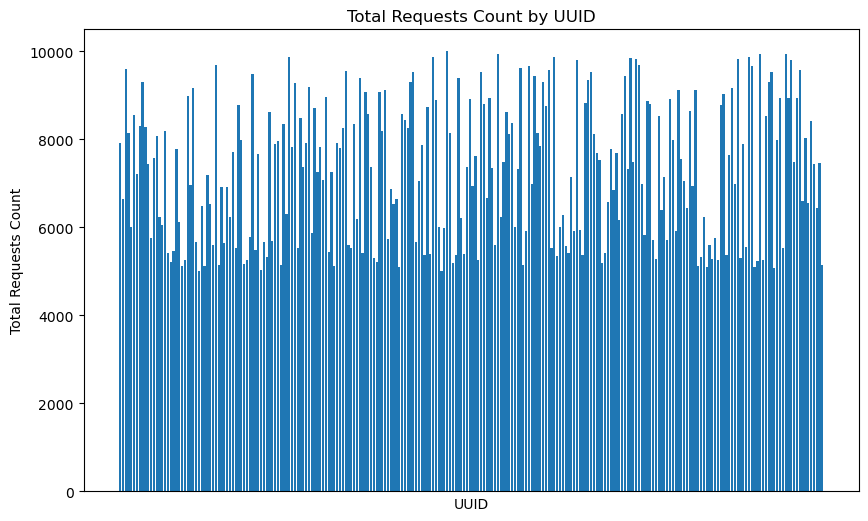

In [ ]:
#aggregation of requests_cnt by uuid, I checked different thresholds to see the distribution (interesting ones: 1-inf , 2000 - 5000, 5000 - 10000, 10000 - inf)
agg_df1 = df.groupby('uuid')['requests_cnt'].sum().reset_index()
agg_df1 = agg_df1[(agg_df1['requests_cnt'] > 5000) & (agg_df1['requests_cnt'] < 10000)]  #example threshold
plt.figure(figsize=(10,6))
plt.bar(agg_df1['uuid'], agg_df1['requests_cnt'])
plt.xlabel('UUID')
plt.ylabel('Total Requests Count')
plt.title('Total Requests Count by UUID')
plt.xticks(ticks =[])
plt.show()

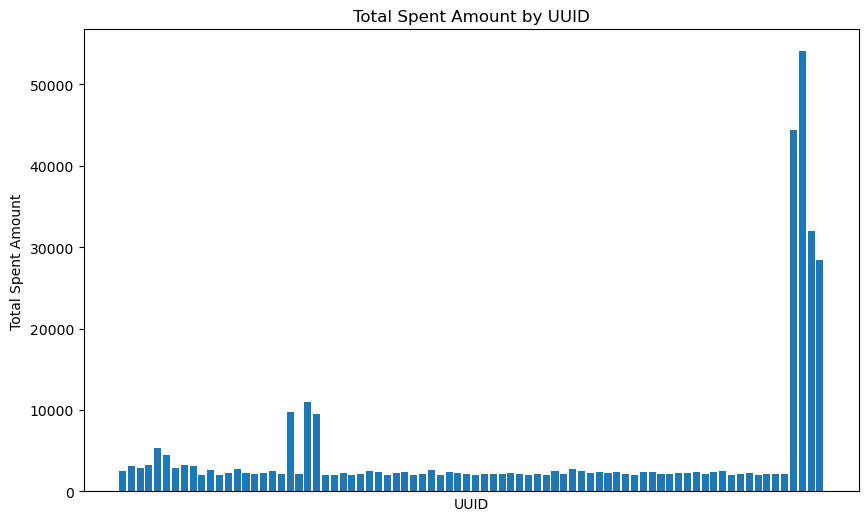

In [14]:
#similar case here for spent_amount
agg_df2 = df.groupby('uuid')['spent_amount'].sum().reset_index()
agg_df2 = agg_df2[agg_df2['spent_amount'] > 2000]  #example threshold, around 3000 is a good cut-off
plt.figure(figsize=(10,6))
plt.bar(agg_df2['uuid'], agg_df2['spent_amount'])
plt.xlabel('UUID')
plt.ylabel('Total Spent Amount')
plt.title('Total Spent Amount by UUID')
plt.xticks(ticks =[])
plt.show()

In [ ]:
#outlier analysis - UUID with highest requests_cnt, from the graph above we can see there are some outliers
max_requests_uuid = agg_df1.loc[agg_df1['requests_cnt'].idxmax()]
print(f'UUID with the highest number of requests: {max_requests_uuid["uuid"]} with {max_requests_uuid["requests_cnt"]} requests')

UUID with the highest number of requests: user_935 with 285050.0 requests


In [15]:
#outlier analysis - UUID with highest spent_amount
max_spent_uuid = agg_df2.loc[agg_df2['spent_amount'].idxmax()]
print(f'UUID with the highest spent amount: {max_spent_uuid["uuid"]} with {max_spent_uuid["spent_amount"]} spent amount')

UUID with the highest spent amount: user_935 with 54032.42 spent amount


In [16]:
#quantiles for spent_amount per uuid
agg_spent = df.groupby('uuid')['spent_amount'].sum().reset_index()
quantiles_spent = agg_spent['spent_amount'].quantile([0.5, 0.75, 0.95]).round()

print("Quantiles for total spent_amount per uuid:")
print(quantiles_spent)

#quantiles for requests_cnt per uuid
agg_requests = df.groupby('uuid')['requests_cnt'].sum().reset_index()
quantiles_requests = agg_requests['requests_cnt'].quantile([0.5, 0.75, 0.95]).round()

print("Quantiles for total requests_cnt per uuid:")
print(quantiles_requests)

Quantiles for total spent_amount per uuid:
0.50     521.0
0.75    1120.0
0.95    1946.0
Name: spent_amount, dtype: float64
Quantiles for total requests_cnt per uuid:
0.50    1986.0
0.75    4140.0
0.95    9873.0
Name: requests_cnt, dtype: float64


In [ ]:
#observations above the 0.95 quantile
outliers_spent = agg_spent[agg_spent['spent_amount'] > quantiles_spent[0.95]]
outliers_requests = agg_requests[agg_requests['requests_cnt'] > quantiles_requests[0.95]]
print("UUIDs with spent_amount above 95th percentile:")
print(outliers_spent)
print("UUIDs with requests_cnt above 95th percentile:")
print(outliers_requests)

#checking if outliers overlap
overlap_uuids = set(outliers_spent['uuid']).intersection(set(outliers_requests['uuid']))
print("UUIDs that are outliers in both spent_amount and requests_cnt:")
print(overlap_uuids)
print(f'Number of overlapping outlier UUIDs: {len(overlap_uuids)}')


UUIDs with spent_amount above 95th percentile:
            uuid  spent_amount
192     user_114       2476.25
201   user_11418       3087.00
212   user_11435       2866.76
270   user_11549       3200.26
280   user_11566       5344.15
...          ...           ...
1766    user_909       2146.40
1793    user_933      44329.76
1795    user_935      54032.42
1796    user_936      32019.97
1797    user_937      28361.01

[95 rows x 2 columns]
UUIDs with requests_cnt above 95th percentile:
            uuid  requests_cnt
192     user_114       12792.0
201   user_11418       16350.0
280   user_11566       27900.0
322   user_11637       24550.0
410   user_11808       15200.0
...          ...           ...
1766    user_909       11280.0
1793    user_933      120850.0
1795    user_935      285050.0
1796    user_936      101300.0
1797    user_937      154300.0

[94 rows x 2 columns]
UUIDs that are outliers in both spent_amount and requests_cnt:
{'user_451', 'user_213', 'user_665', 'user_459', 'use

In [26]:
# Outlier detection using Z-score method
mean_spent = df['spent_amount'].mean()
std_spent = df['spent_amount'].std()

df['z_score'] = (df['spent_amount'] - mean_spent) / std_spent

outliers_zscore = df[np.abs(df['z_score']) >= 2]

print(f"Found {len(outliers_zscore)} outliers (Z-score method).")
print(outliers_zscore.head())

Found 457 outliers (Z-score method).
           uuid      day_id   license    model    feature  requests_cnt  \
248    user_935  2025-04-07   Premium  Model_C  Feature_5        2600.0   
678    user_935  2025-04-07   Premium  Model_C  Feature_1        3600.0   
1083  user_1934  2025-04-24  Standard  Model_A  Feature_3         900.0   
1148  user_1937  2025-04-05  Standard  Model_D  Feature_2        2600.0   
1162  user_1934  2025-04-22  Standard  Model_A  Feature_2         850.0   

      spent_amount  predicted_spent   residuals    z_score  
248          464.5       550.724404  -86.224404  12.032198  
678          714.5       762.004002  -47.504002  18.683170  
1083         322.0       191.549088  130.450912   8.241144  
1148         452.0       550.724404  -98.724404  11.699649  
1162         299.5       180.985108  118.514892   7.642557  


In [ ]:
# the amount of outliers is different from the previous method, indicating different sensitivity to outlier detection
# if I had to do a deeper analysis I would build a linear regression model and use residual analysis to detect outliers

In [ ]:
#user segmentation based on requests_cnt
#many thresholds could be used, depending on the business needs and the preffered distribution of user groups
agg_df2 = df.groupby('uuid')['requests_cnt'].sum().reset_index()

requests_cnt_bins = [0, 10000, 20000, np.inf] #thresholds based on a previous graph
labels = ['Low', 'Medium', 'High']

user_groups = pd.cut(agg_df2['requests_cnt'], bins=requests_cnt_bins, labels=labels, include_lowest=True)

group_counts = user_groups.value_counts().sort_index()

print("User segmentation based on requests_cnt:")
print(group_counts)

User segmentation based on requests_cnt:
requests_cnt
Low       1779
Medium      78
High         9
Name: count, dtype: int64


In [38]:
#user segmentation based on spent_amount
user_total_spent = df.groupby('uuid')['spent_amount'].sum().reset_index()

spent_amount_bins = [0, 2000, 3000, np.inf] #thresholds based on a previous graph
labels = ['Low', 'Medium', 'High']

user_groups = pd.cut(user_total_spent['spent_amount'], bins=spent_amount_bins, labels=labels, include_lowest=True)

group_counts = user_groups.value_counts().sort_index()

print("User segmentation based on spent_amount:")
print(group_counts)

User segmentation based on spent_amount:
spent_amount
Low       1786
Medium      67
High        13
Name: count, dtype: int64


**Clusterization based on KNN**

--- User-level aggregated data ---
          total_requests  total_spent  avg_requests_per_day  \
uuid                                                          
user_1            7917.0      1538.96             71.972727   
user_10           4260.0       843.37             46.813187   
user_100          3628.0      1128.27             37.020408   
user_101          1880.0       624.96             23.209877   
user_102          3346.0       671.40             37.595506   

          unique_features_used preferred_model  
uuid                                            
user_1                       5         Model_E  
user_10                      5         Model_C  
user_100                     5         Model_A  
user_101                     5         Model_B  
user_102                     5         Model_D  
------------------------------ 



c:\Users\Pc\anaconda3\envs\JBapp\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\Pc\anaconda3\envs\JBapp\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\Pc\anaconda3\envs\JBapp\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
c:\Users\Pc\anaconda3\envs\JBapp\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known

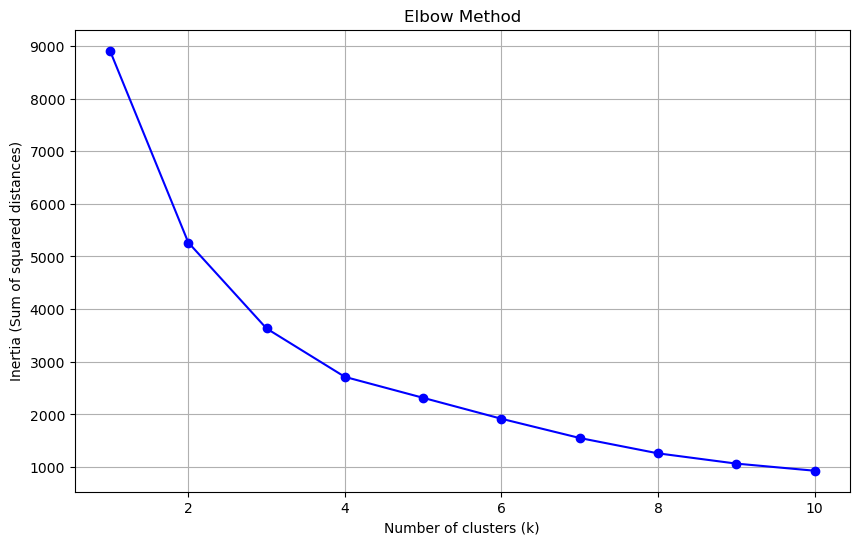

In [29]:
#User-level data aggregation (Feature Engineering)

#Data aggregation
user_df = df.groupby('uuid').agg(
    total_requests=pd.NamedAgg(column='requests_cnt', aggfunc='sum'),
    total_spent=pd.NamedAgg(column='spent_amount', aggfunc='sum'),

    #Average number of requests per day of activity (since df is already at the day level)
    avg_requests_per_day=pd.NamedAgg(column='requests_cnt', aggfunc='mean'), 
    
    unique_features_used=pd.NamedAgg(column='feature', aggfunc='nunique')
)

#Data aggregation for categorical features (dominant model)
#Find the model with the highest number of REQUESTS (not just days)
user_model_requests = df.groupby(['uuid', 'model'])['requests_cnt'].sum().reset_index()
idx = user_model_requests.groupby('uuid')['requests_cnt'].idxmax()
preferred_model = user_model_requests.loc[idx].set_index('uuid')['model']

user_df = user_df.join(preferred_model.rename('preferred_model'))

print("--- User-level aggregated data ---")
print(user_df.head())
print("-" * 30, "\n")

#Identify numeric and categorical columns
numeric_features = ['total_requests', 'total_spent', 'avg_requests_per_day', 'unique_features_used']
categorical_features = ['preferred_model']

#Create transformation pipelines
#For numeric data: Impute missing values (if any) and scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())                 
])

#For categorical data: Impute missing values and encode (OneHotEncoding)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) 
])

#Merging both pipelines using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

#Applying preprocessing
X_processed = preprocessor.fit_transform(user_df)

#Finding the Optimal Number of Clusters (Elbow Method)

inertia = []
K_range = range(1, 11) # Testing k from 1 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_processed)
    inertia.append(kmeans.inertia_)

#Plotting the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of squared distances)')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

c:\Users\Pc\anaconda3\envs\JBapp\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


--- CLUSTER PROFILE (AVERAGE VALUES) ---
cluster                         0              1           2
cluster_size          1562.000000       4.000000  300.000000
total_requests        3574.013444  165375.000000  159.806667
total_spent            851.178412   39685.790000   42.098333
avg_requests_per_day    53.073903    2763.374487   29.294684
unique_features_used     4.882843       5.000000    2.266667
Model_A                  0.316261       0.250000    0.330000
Model_B                  0.186940       0.250000    0.163333
Model_C                  0.202305       0.250000    0.200000
Model_D                  0.203585       0.250000    0.216667
Model_E                  0.090909       0.000000    0.090000
------------------------------ 



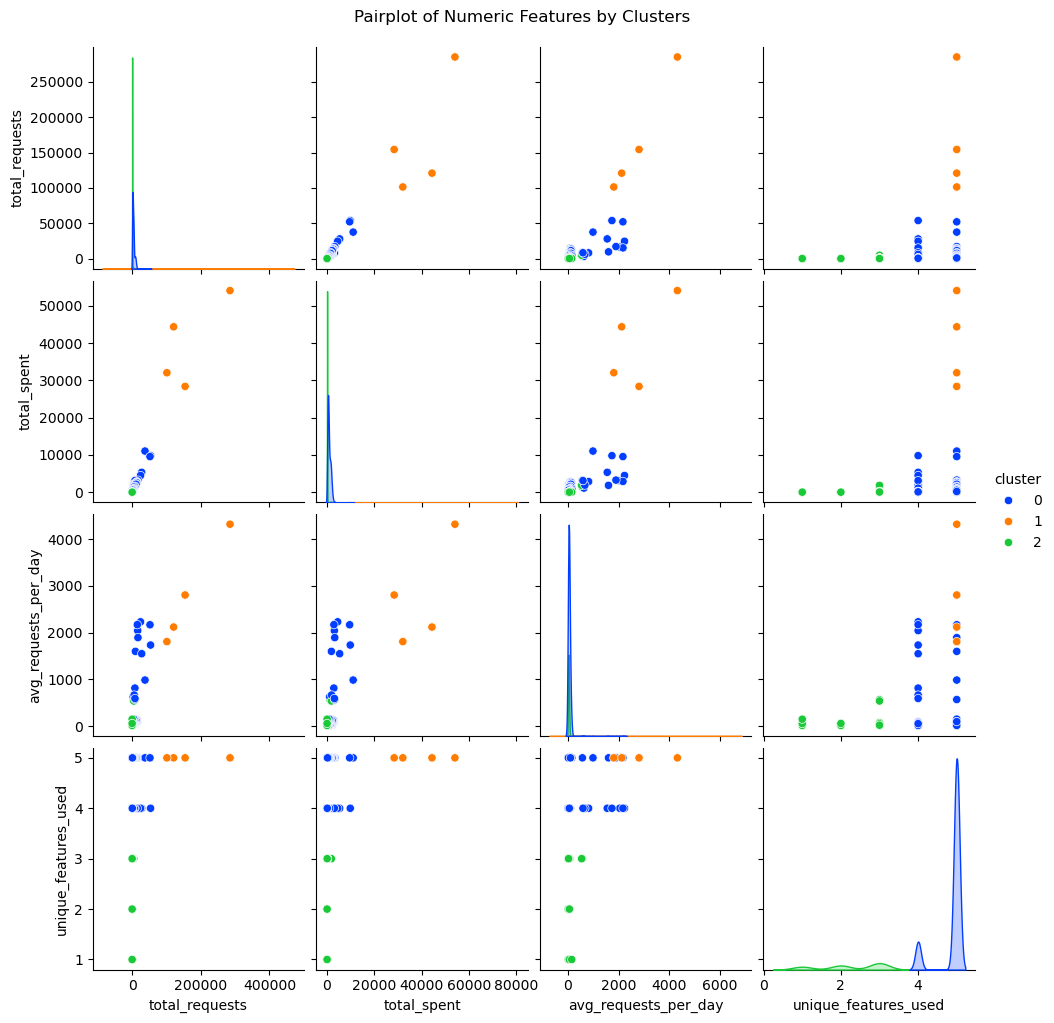

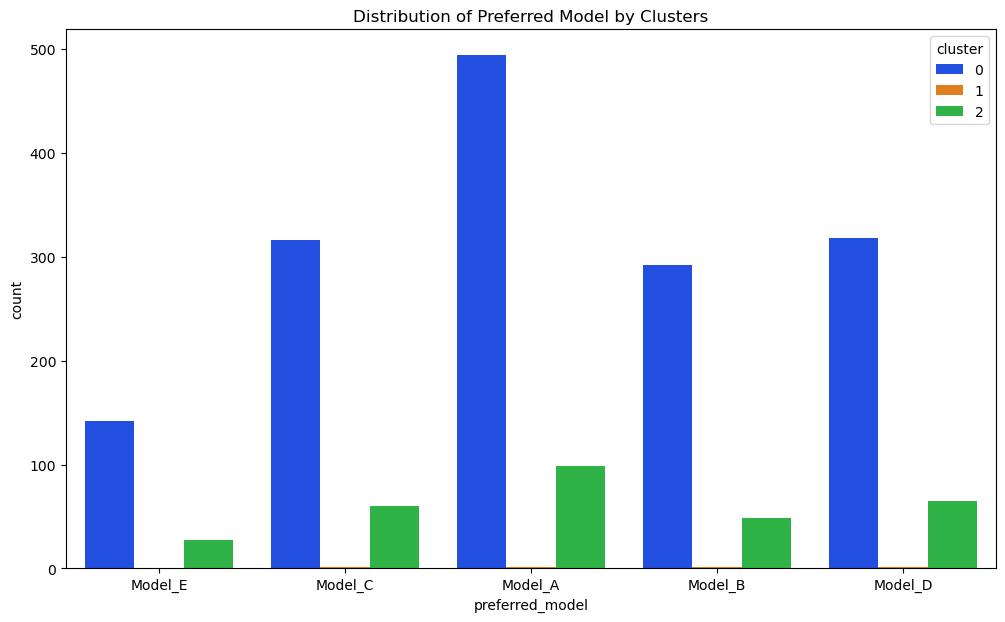

In [33]:
#Running the final K-Means model

#Based on the elbow analysis k=3
OPTIMAL_K = 3

kmeans = KMeans(n_clusters=OPTIMAL_K, n_init=10, random_state=42)
kmeans.fit(X_processed)

#Assigning cluster labels back to the dataframe
user_df['cluster'] = kmeans.labels_

#Cluster Analysis and Interpretation (Creating Personas)
cluster_analysis_numeric = user_df.groupby('cluster')[numeric_features].mean()

cluster_analysis_categorical = user_df.groupby('cluster')['preferred_model'].value_counts(normalize=True).unstack().fillna(0)

cluster_size = user_df['cluster'].value_counts().sort_index().to_frame(name='cluster_size')

cluster_profile = pd.concat([cluster_size, cluster_analysis_numeric, cluster_analysis_categorical], axis=1)

print("--- CLUSTER PROFILE (AVERAGE VALUES) ---")
print(cluster_profile.T)
print("-" * 30, "\n")

#Visualization

# Using `pairplot` to visualize relationships between features, coloring by cluster
# We only select numeric features, as these show dependencies
sns.pairplot(user_df, hue='cluster', vars=numeric_features, palette='bright')
plt.suptitle('Pairplot of Numeric Features by Clusters', y=1.02)
plt.show()

# Visualization of preferred model
plt.figure(figsize=(12, 7))
sns.countplot(data=user_df, x='preferred_model', hue='cluster', palette='bright')
plt.title('Distribution of Preferred Model by Clusters')
plt.show()

In [35]:
#Based on the cluster profiles and visualizations, we can interpret and create user personas for each cluster. 

**Model-based analysis**

In [36]:
#model usage distribution across user segments (based on requests_cnt)
#for simplicity, we will reuse the previous bins
user_total_requests = df.groupby('uuid')['requests_cnt'].sum()

labels = ['Low_Activity_User', 'Medium_Activity_User', 'High_Activity_User']

user_segments = pd.cut(user_total_requests, 
                    bins=requests_cnt_bins, 
                    labels=labels, 
                    include_lowest=True)

user_segments.name = 'user_segment'

df['user_segment'] = df['uuid'].map(user_segments)

model_segment_df = df.groupby(['user_segment', 'model'])['uuid'].nunique().reset_index()

model_segment_df.rename(columns={'uuid': 'unique_user_count'}, inplace=True)

print("Model usage distribution across user segments (based on requests_cnt):")
print(model_segment_df)

Model usage distribution across user segments (based on requests_cnt):
            user_segment    model  unique_user_count
0      Low_Activity_User  Model_A                816
1      Low_Activity_User  Model_B                596
2      Low_Activity_User  Model_C                598
3      Low_Activity_User  Model_D                649
4      Low_Activity_User  Model_E                423
5   Medium_Activity_User  Model_A                 21
6   Medium_Activity_User  Model_B                 13
7   Medium_Activity_User  Model_C                 41
8   Medium_Activity_User  Model_D                 53
9   Medium_Activity_User  Model_E                 17
10    High_Activity_User  Model_A                  6
11    High_Activity_User  Model_B                  1
12    High_Activity_User  Model_C                  5
13    High_Activity_User  Model_D                  3
14    High_Activity_User  Model_E                  1


C:\Users\Pc\AppData\Local\Temp\ipykernel_9596\3519015635.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_segment_df = df.groupby(['user_segment', 'model'])['uuid'].nunique().reset_index()


In [39]:
#model usage distribution across user segments (based on spent_amount)
#for simplicity, we will reuse the previous bins
user_total_spent = df.groupby('uuid')['spent_amount'].sum()

labels = ['Low_Activity_User', 'Medium_Activity_User', 'High_Activity_User']

user_segments = pd.cut(user_total_spent, 
                    bins=spent_amount_bins, 
                    labels=labels, 
                    include_lowest=True)

user_segments.name = 'user_segment'

df['user_segment'] = df['uuid'].map(user_segments)

model_segment_df = df.groupby(['user_segment', 'model'])['uuid'].nunique().reset_index()

model_segment_df.rename(columns={'uuid': 'unique_user_count'}, inplace=True)

print("Model usage distribution across user segments (based on spent_amount):")
print(model_segment_df)

Model usage distribution across user segments (based on spent_amount):
            user_segment    model  unique_user_count
0      Low_Activity_User  Model_A                813
1      Low_Activity_User  Model_B                591
2      Low_Activity_User  Model_C                604
3      Low_Activity_User  Model_D                655
4      Low_Activity_User  Model_E                429
5   Medium_Activity_User  Model_A                 23
6   Medium_Activity_User  Model_B                 16
7   Medium_Activity_User  Model_C                 33
8   Medium_Activity_User  Model_D                 46
9   Medium_Activity_User  Model_E                 11
10    High_Activity_User  Model_A                  7
11    High_Activity_User  Model_B                  3
12    High_Activity_User  Model_C                  7
13    High_Activity_User  Model_D                  4
14    High_Activity_User  Model_E                  1


C:\Users\Pc\AppData\Local\Temp\ipykernel_9596\146714904.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  model_segment_df = df.groupby(['user_segment', 'model'])['uuid'].nunique().reset_index()


**Spent amount per model**

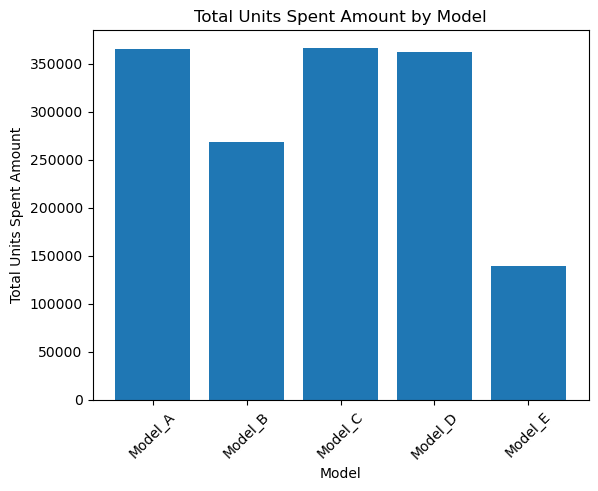

In [40]:
agg_df = df.groupby('model')['spent_amount'].sum().reset_index()
plt.bar(agg_df['model'], agg_df['spent_amount'])
plt.xlabel('Model')
plt.ylabel('Total Units Spent Amount')
plt.title('Total Units Spent Amount by Model')
plt.xticks(rotation=45)
plt.show()

In [41]:
#license usage analysis

license_usage = df.groupby(['model', 'license'])['requests_cnt'].sum().reset_index()
license_usage = license_usage.sort_values(by='requests_cnt', ascending=False)
for i in range(len(df['license'].unique())):
    license_block = license_usage[license_usage['license'] == df['license'].unique()[i]]
    print(license_block)

      model  license  requests_cnt
10  Model_C  Premium      676182.0
14  Model_D  Premium      406016.0
2   Model_A  Premium      258014.0
18  Model_E  Premium      206760.0
6   Model_B  Premium      172656.0
      model license  requests_cnt
8   Model_C   Basic      366564.0
12  Model_D   Basic      333519.0
0   Model_A   Basic      181463.0
4   Model_B   Basic      104788.0
16  Model_E   Basic       91789.0
      model     license  requests_cnt
13  Model_D  Enterprise      548537.0
9   Model_C  Enterprise      498204.0
1   Model_A  Enterprise      309526.0
5   Model_B  Enterprise      294919.0
17  Model_E  Enterprise      274188.0
      model   license  requests_cnt
15  Model_D  Standard      606078.0
11  Model_C  Standard      400846.0
3   Model_A  Standard      242930.0
19  Model_E  Standard      161064.0
7   Model_B  Standard      158008.0


In [42]:
#analysis of average spent_amount per model
model_usage = df.groupby('model')['spent_amount'].mean().reset_index()
print(model_usage)

     model  spent_amount
0  Model_A      9.596685
1  Model_B     11.603898
2  Model_C     15.005187
3  Model_D     14.806012
4  Model_E     10.946868


In [43]:
#feature usage analysis
feature_usage = df.groupby(['model', 'feature'])['requests_cnt'].sum().reset_index()
feature_usage = feature_usage.sort_values(by='requests_cnt', ascending=False)
print(feature_usage)

      model    feature  requests_cnt
10  Model_C  Feature_1      937253.0
15  Model_D  Feature_1      798043.0
16  Model_D  Feature_2      603601.0
11  Model_C  Feature_2      404161.0
0   Model_A  Feature_1      363290.0
12  Model_C  Feature_3      358344.0
20  Model_E  Feature_1      329741.0
1   Model_A  Feature_2      295124.0
6   Model_B  Feature_2      252778.0
17  Model_D  Feature_3      251417.0
5   Model_B  Feature_1      241452.0
2   Model_A  Feature_3      231346.0
21  Model_E  Feature_2      200811.0
7   Model_B  Feature_3      184196.0
13  Model_C  Feature_4      162050.0
18  Model_D  Feature_4      124580.0
19  Model_D  Feature_5      116509.0
22  Model_E  Feature_3      110376.0
14  Model_C  Feature_5       79988.0
3   Model_A  Feature_4       69566.0
23  Model_E  Feature_4       52162.0
24  Model_E  Feature_5       40711.0
9   Model_B  Feature_5       35448.0
4   Model_A  Feature_5       32607.0
8   Model_B  Feature_4       16497.0


**Retension Analysis**

In [ ]:
#Analysis of retention rate of uuid based on requests_cnt and spent_amount

def calculate_retention_metrics(df):
    retention_requests = df[df['requests_cnt'] > 0].shape[0] / df.shape[0]
    retention_spent = df[df['spent_amount'] > 0].shape[0] / df.shape[0]
    return retention_requests, retention_spent
    
user_retention = df.groupby('uuid').apply(calculate_retention_metrics).reset_index()

#Split the tuple into two separate columns
user_retention[['retention_requests', 'retention_spent']] = pd.DataFrame(user_retention[0].tolist(), index=user_retention.index)
user_retention = user_retention.drop(columns=[0])
print(user_retention.head())

#mean retention rates
mean_retention_requests = user_retention['retention_requests'].mean()
mean_retention_spent = user_retention['retention_spent'].mean()
print(f'Mean Retention Rate based on Requests Count: {mean_retention_requests}')
print(f'Mean Retention Rate based on Spent Amount: {mean_retention_spent}')



       uuid  retention_requests  retention_spent
0    user_1                 1.0              1.0
1   user_10                 1.0              1.0
2  user_100                 1.0              1.0
3  user_101                 1.0              1.0
4  user_102                 1.0              1.0
Mean Retention Rate based on Requests Count: 1.0
Mean Retention Rate based on Spent Amount: 1.0


C:\Users\Pc\AppData\Local\Temp\ipykernel_20444\2767514790.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_retention = df.groupby('uuid').apply(calculate_retention_metrics).reset_index()


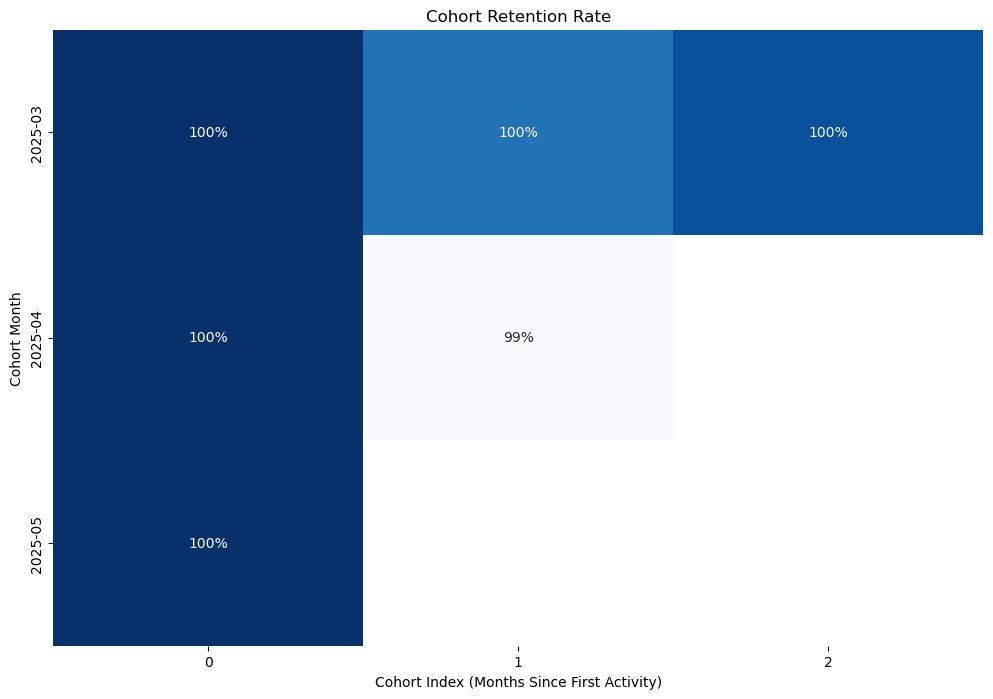

In [21]:
#cohort analysis
from operator import attrgetter


df['date'] = pd.to_datetime(df['day_id'], format='%Y-%m-%d')
df['cohort_month'] = df.groupby('uuid')['date'].transform('min').dt.to_period('M')
df['activity_month'] = df['date'].dt.to_period('M')
cohort_data = df.groupby(['cohort_month', 'activity_month']).agg(
    total_users=('uuid', 'nunique'),
    active_users=('uuid', lambda x: x.nunique())
).reset_index()
cohort_data['cohort_index'] = (cohort_data['activity_month'] - cohort_data['cohort_month']).apply(attrgetter('n'))
cohort_pivot = cohort_data.pivot_table(index='cohort_month', columns='cohort_index', values='active_users')

cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.heatmap(retention_matrix, annot=True, fmt='.0%', cmap='Blues', cbar=False)
plt.title('Cohort Retention Rate')
plt.ylabel('Cohort Month')
plt.xlabel('Cohort Index (Months Since First Activity)')
plt.show()



**cost per request analysis**

Average Cost per Request: 0.2791191809742142
Cost per Request by Model:
     model  cost_per_request
0  Model_A          0.369166
1  Model_B          0.366373
2  Model_C          0.189598
3  Model_D          0.192177
4  Model_E          0.190301
Cost per Request by Feature:
     feature  cost_per_request
0  Feature_1          0.275974
1  Feature_2          0.280180
2  Feature_3          0.282840
3  Feature_4          0.276937
4  Feature_5          0.282122
Cost per Request by License:
      license  cost_per_request
0       Basic          0.278792
1  Enterprise          0.277053
2     Premium          0.276352
3    Standard          0.282439


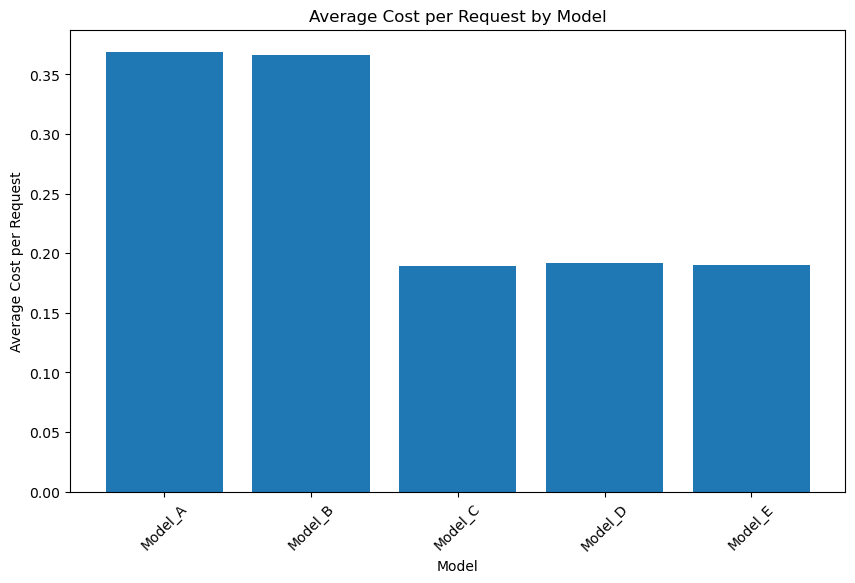

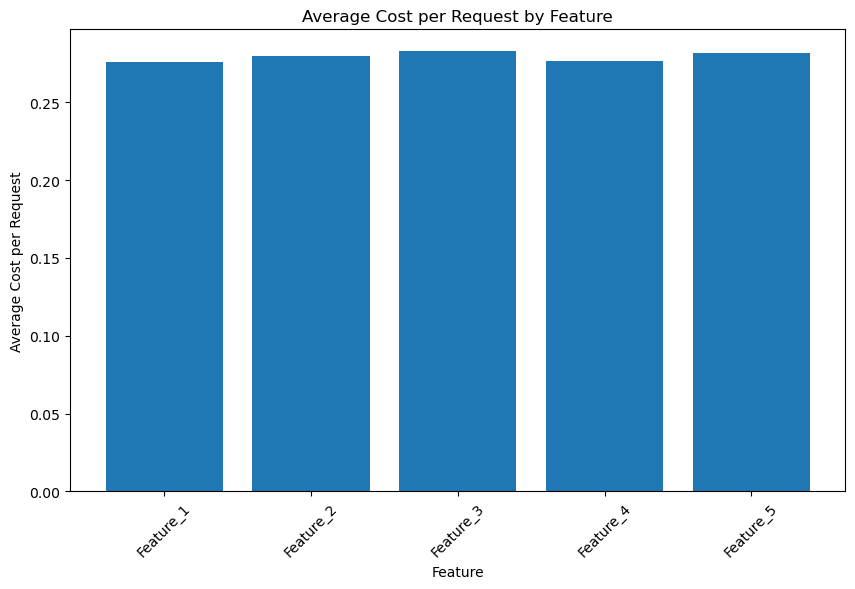

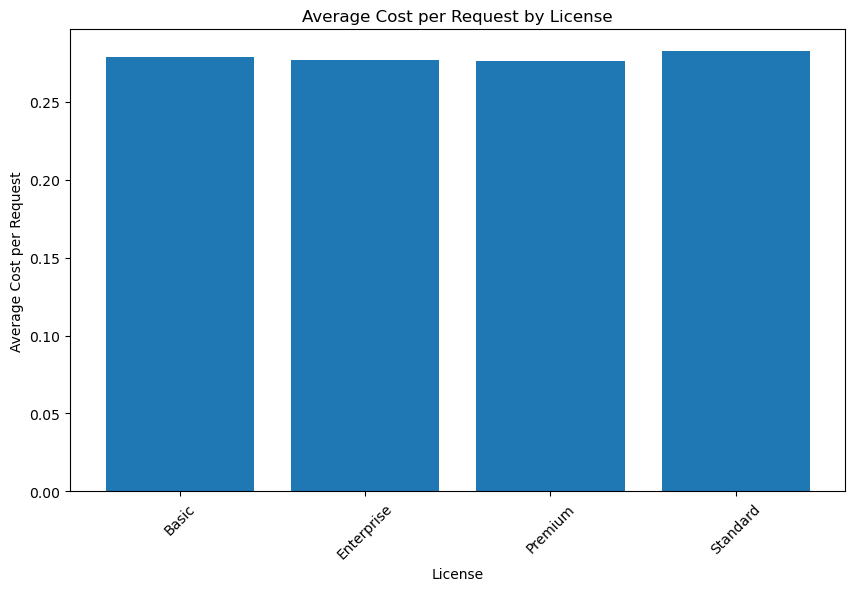

In [ ]:
df['cost_per_request'] = df.apply(lambda row: row['spent_amount'] / row['requests_cnt'] if row['requests_cnt'] > 0 else 0, axis=1)
avg_cost_per_request = df['cost_per_request'].mean()
print(f'Average Cost per Request: {avg_cost_per_request}')

#cost per request by model
model_cost_per_request = df.groupby('model')['cost_per_request'].mean().reset_index()
print("Cost per Request by Model:")
print(model_cost_per_request)

#cost per request by feature
feature_cost_per_request = df.groupby('feature')['cost_per_request'].mean().reset_index()
print("Cost per Request by Feature:")
print(feature_cost_per_request)

#cost per request by license
license_cost_per_request = df.groupby('license')['cost_per_request'].mean().reset_index()
print("Cost per Request by License:")
print(license_cost_per_request)

#visualization of cost per request by model
plt.figure(figsize=(10,6))
plt.bar(model_cost_per_request['model'], model_cost_per_request['cost_per_request'])
plt.xlabel('Model')
plt.ylabel('Average Cost per Request')
plt.title('Average Cost per Request by Model')
plt.xticks(rotation=45)
plt.show()

#visualization of cost per request by feature
plt.figure(figsize=(10,6))
plt.bar(feature_cost_per_request['feature'], feature_cost_per_request['cost_per_request'])
plt.xlabel('Feature')
plt.ylabel('Average Cost per Request')
plt.title('Average Cost per Request by Feature')
plt.xticks(rotation=45)
plt.show()

#visualization of cost per request by license
plt.figure(figsize=(10,6))
plt.bar(license_cost_per_request['license'], license_cost_per_request['cost_per_request'])
plt.xlabel('License')
plt.ylabel('Average Cost per Request')
plt.title('Average Cost per Request by License')
plt.xticks(rotation=45)
plt.show()

**user journey**

--- Migration Matrix (March -> May) ---
May_Model    Model_A  Model_B  Model_C  Model_D  Model_E
March_Model                                             
Model_A          456        0        0        3        1
Model_B            0      275        0        0        0
Model_C            4        1      290        0        0
Model_D            6        2        2      280        0
Model_E            2        0        0        0      132

Description: Rows are models in March, Columns are models in May.



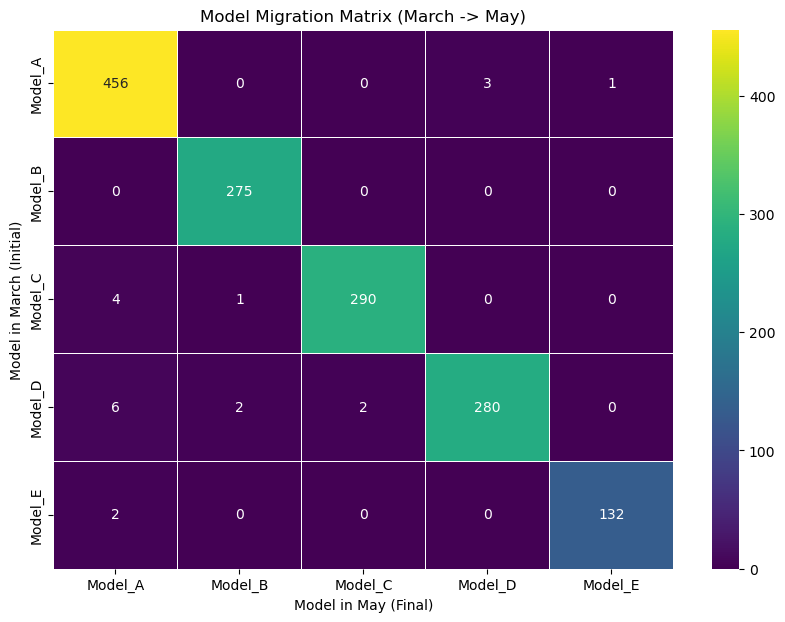

--- User Progression Summary (March -> May) ---
Progression_Type
No Change    100.0
Name: proportion, dtype: float64




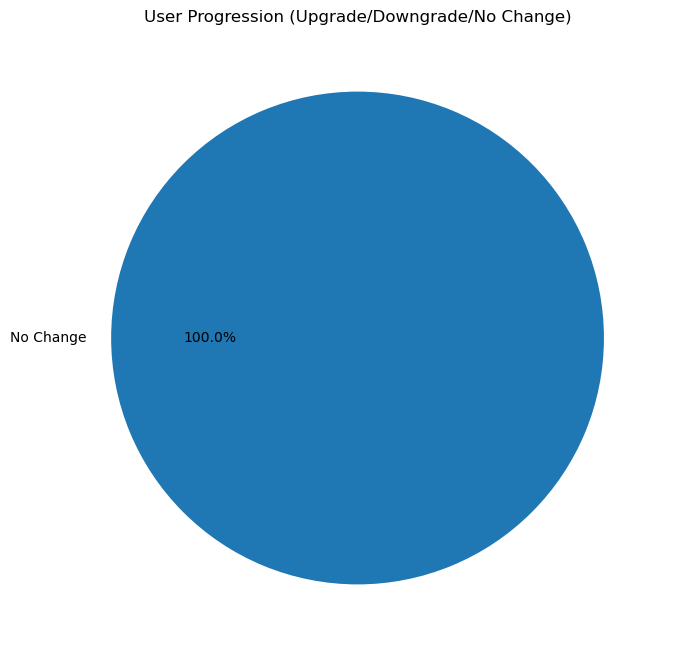

In [46]:
#Data Preparation
df['day_id'] = pd.to_datetime(df['day_id'])
df['month'] = df['day_id'].dt.month

#Finding the dominant model for each user in each month

monthly_usage = df.groupby(['uuid', 'month', 'model'])['requests_cnt'].sum().reset_index()
monthly_usage_sorted = monthly_usage.sort_values(by='requests_cnt', ascending=False)
dominant_model = monthly_usage_sorted.drop_duplicates(subset=['uuid', 'month'], keep='first')

#Pivoting the data to create a user-month matrix
journey_pivot = dominant_model.pivot(index='uuid', 
                                    columns='month', 
                                    values='model')

#Changing column names for readability
journey_pivot = journey_pivot.rename(columns={
    3: 'March_Model',
    4: 'April_Model',
    5: 'May_Model'
})

#Analyzing "Switching" (March vs May)

#Focusing on the cohort of users who were active in both March and May
#Removing users who were not active in both months
cohort_df = journey_pivot[['March_Model', 'May_Model']].dropna()

migration_matrix = pd.crosstab(
    cohort_df['March_Model'],  
    cohort_df['May_Model']     
)

print("--- Migration Matrix (March -> May) ---")
print(migration_matrix)
print("\nDescription: Rows are models in March, Columns are models in May.\n")

#Visualizing the migration matrix (Heatmap)

plt.figure(figsize=(10, 7))
sns.heatmap(migration_matrix, 
            annot=True,     # Show numbers in cells
            fmt='d',        # Format as integers
            cmap='viridis', # Color scheme
            linewidths=.5)
plt.title('Model Migration Matrix (March -> May)')
plt.ylabel('Model in March (Initial)')
plt.xlabel('Model in May (Final)')
plt.show()

#Quantifying "Upgrade"

# Assuming a cost hierarchy: model_A (cheap) < model_B (medium) < model_C (expensive)
# If unsure, you can infer it from the 'cost_per_request' analysis
model_hierarchy = {
    'model_C': 1,  # Example cheap model
    'model_B': 2  # Example medium model
}

# Map ranks to our cohort
cohort_df['March_Rank'] = cohort_df['March_Model'].map(model_hierarchy)
cohort_df['May_Rank'] = cohort_df['May_Model'].map(model_hierarchy)

# Calculate change in rank
cohort_df['Progression'] = cohort_df['May_Rank'] - cohort_df['March_Rank']

# Define progression types
def categorize_progression(change):
    if change > 0:
        return 'Upgrade'
    elif change < 0:
        return 'Downgrade'
    else:
        return 'No Change'

cohort_df['Progression_Type'] = cohort_df['Progression'].apply(categorize_progression)

#Show summary
progression_summary = cohort_df['Progression_Type'].value_counts(normalize=True) * 100

print("--- User Progression Summary (March -> May) ---")
print(progression_summary)
print("\n")

#Visualizing the summary
progression_summary.plot(kind='pie',
                        autopct='%.1f%%',
                        figsize=(8, 8),
                        title='User Progression (Upgrade/Downgrade/No Change)')
plt.ylabel('') # Remove Y-axis label
plt.show()


**Time-based aggregation**

Daily Aggregation:
        date  total_requests  total_spent
0 2025-03-01         14033.0      3250.03
1 2025-03-02         15594.0      3495.51
2 2025-03-03         68623.0     16474.98
3 2025-03-04         65634.0     16044.44
4 2025-03-05         70407.0     17194.45
Weekly Aggregation:
        date  total_requests  total_spent
0 2025-03-02         29627.0      6745.54
1 2025-03-09        374804.0     92386.44
2 2025-03-16        398361.0    101481.88
3 2025-03-23        394207.0     95973.88
4 2025-03-30        396381.0     90452.57
Monthly Aggregation:
        date  total_requests  total_spent
0 2025-03-31       1668402.0    403473.18
1 2025-04-30       2056461.0    494638.82
2 2025-05-31       2567188.0    602801.34


C:\Users\Pc\AppData\Local\Temp\ipykernel_9596\3093071598.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_agg = df.groupby(pd.Grouper(key='date', freq='M')).agg(


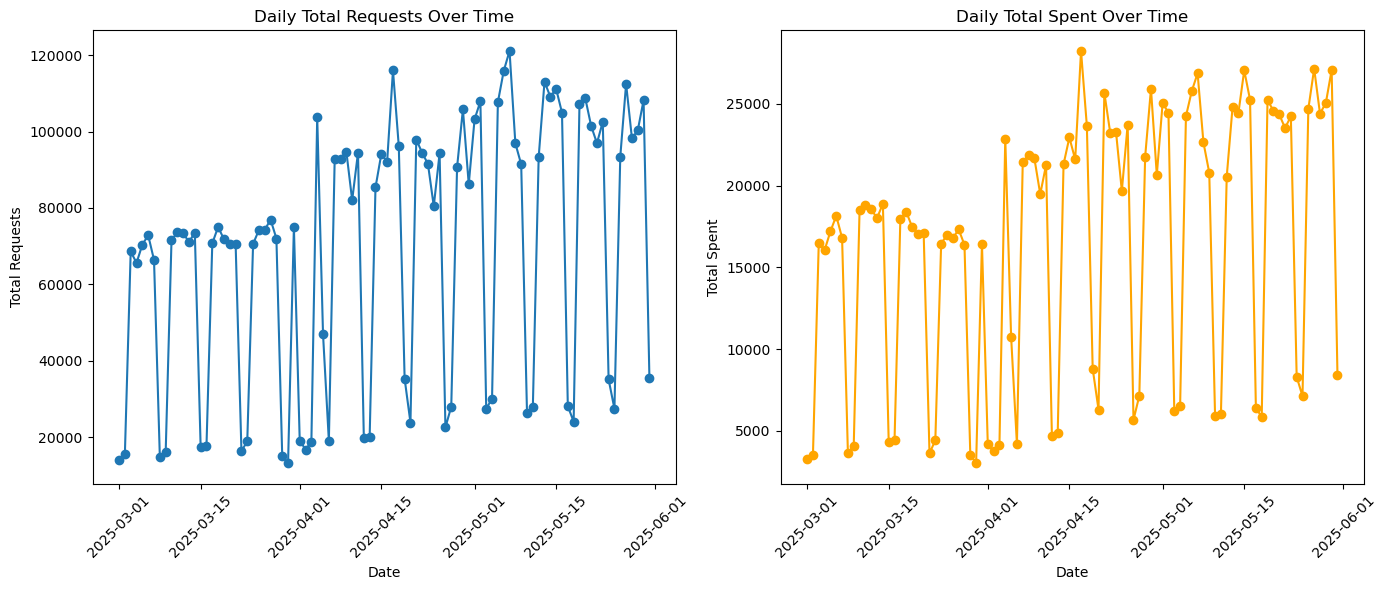

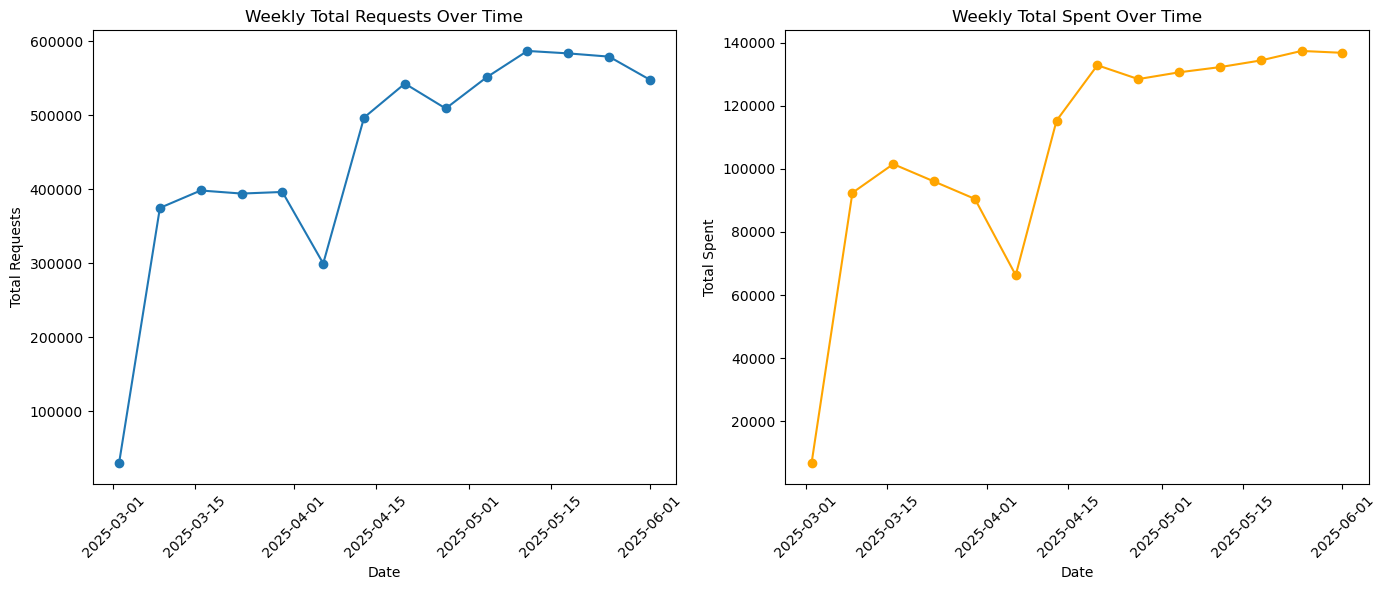

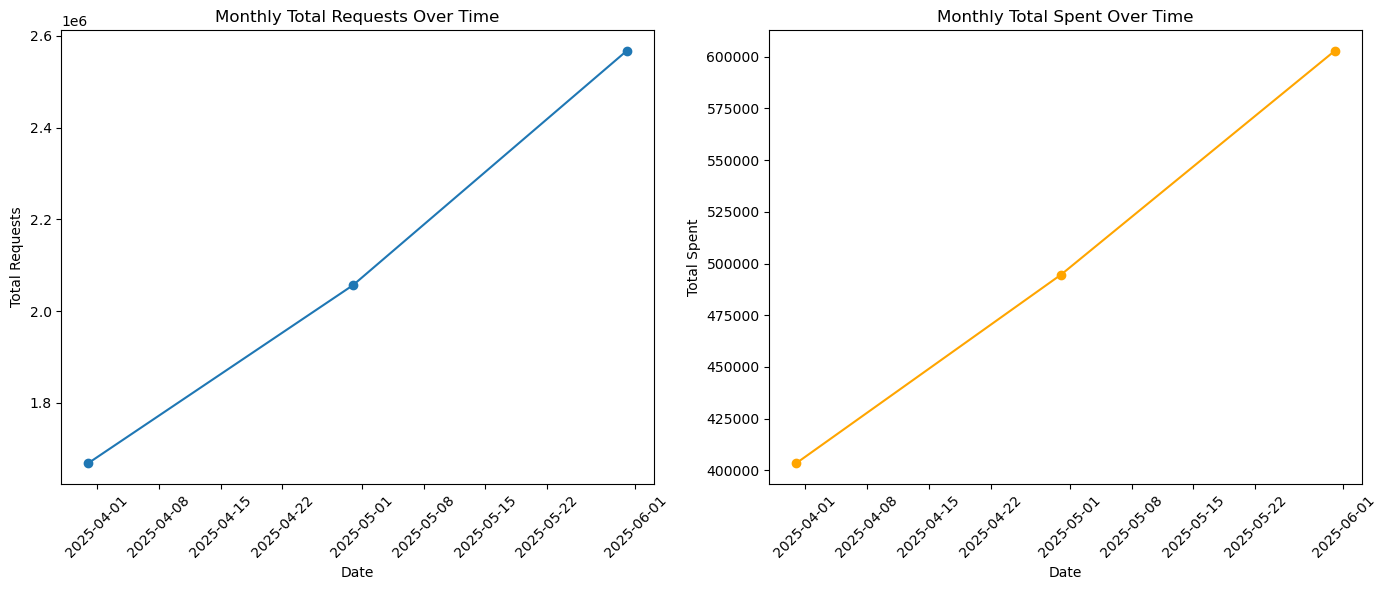

In [49]:
#Aggregate data at daily, weekly, or monthly levels to analyze trends over time and provide different perspectives
df['date'] = pd.to_datetime(df['day_id'], format='%Y-%m-%d')
daily_agg = df.groupby('date').agg(
    total_requests=('requests_cnt', 'sum'),
    total_spent=('spent_amount', 'sum')
).reset_index()
weekly_agg = df.groupby(pd.Grouper(key='date', freq='W')).agg(
    total_requests=('requests_cnt', 'sum'),
    total_spent=('spent_amount', 'sum')
).reset_index()
monthly_agg = df.groupby(pd.Grouper(key='date', freq='M')).agg(
    total_requests=('requests_cnt', 'sum'),
    total_spent=('spent_amount', 'sum')
).reset_index()
print("Daily Aggregation:")
print(daily_agg.head())
print("Weekly Aggregation:")
print(weekly_agg.head())
print("Monthly Aggregation:")
print(monthly_agg.head())

# Visualization of aggregated daily data
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(daily_agg['date'], daily_agg['total_requests'], marker='o')
plt.title('Daily Total Requests Over Time')
plt.xlabel('Date')
plt.ylabel('Total Requests')
plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
plt.plot(daily_agg['date'], daily_agg['total_spent'], marker='o', color='orange')
plt.title('Daily Total Spent Over Time')
plt.xlabel('Date')
plt.ylabel('Total Spent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualization of aggregated weekly data
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(weekly_agg['date'], weekly_agg['total_requests'], marker='o')
plt.title('Weekly Total Requests Over Time')
plt.xlabel('Date')
plt.ylabel('Total Requests')
plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
plt.plot(weekly_agg['date'], weekly_agg['total_spent'], marker='o', color='orange')
plt.title('Weekly Total Spent Over Time')
plt.xlabel('Date')
plt.ylabel('Total Spent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualization of aggregated monthly data
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(monthly_agg['date'], monthly_agg['total_requests'], marker='o')
plt.title('Monthly Total Requests Over Time')
plt.xlabel('Date')
plt.ylabel('Total Requests')
plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
plt.plot(monthly_agg['date'], monthly_agg['total_spent'], marker='o', color='orange')
plt.title('Monthly Total Spent Over Time')
plt.xlabel('Date')
plt.ylabel('Total Spent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

